**On the use of LSTM (Long short-term memory) a RNNs (Recurrent Neural Networks) architecture to predict FaaS Traces**


---
> Inspiring by recent work on VM Workload prediction with LSTM RNN(Long short-term memory Recurrent Neural Networks)

https://www.microsoft.com/en-us/research/wp-content/uploads/2017/10/Resource-Central-SOSP17.pdf
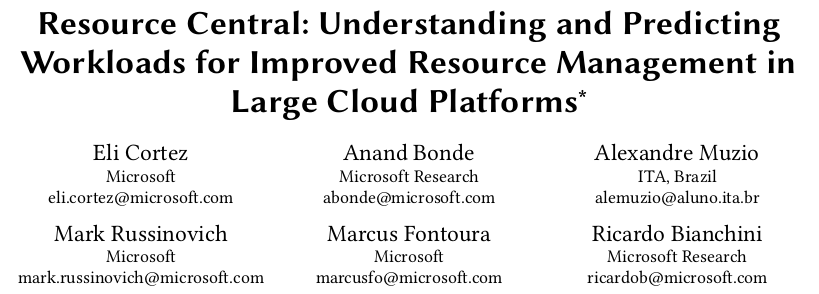

---
***Cloud computing project: Generating FAAS traces***

School: **National Advanced School of Engineering Yaounde, Cameroon**

[ Data ](https://azurecloudpublicdataset2.blob.core.windows.net/azurepublicdatasetv2/azurefunctions_dataset2019/azurefunctions-dataset2019.tar.xz)

[ Data description ](https://github.com/Azure/AzurePublicDataset/blob/master/AzureFunctionsDataset2019.md)

<!-- [ Data two ](https://raw.githubusercontent.com/Azure/AzurePublicDataset/master/data/AzureFunctionsInvocationTraceForTwoWeeksJan2021.rar) -->

[ vm generator ](https://github.com/huaweicloud/trace_generation_rnn) 

<!-- Realised by: **Oreal CHIMI, Mario MANENGONO, Isaac NDEMA, Sylvain KOUEMO, Franklin TALOM, Duhamel TSOPGNI** -->

<!-- Supervisor: **Pr. Alain TCHANA** -->

---

# Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries Installation

In [ ]:
!pip install sklearn

In [ ]:
!pip install statsmodels

In [ ]:
!pip install torch

# Import of libraries

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from typing import NamedTuple
from enum import Enum
from abc import ABC, abstractmethod
import collections
from collections import namedtuple
from torch.utils.data import DataLoader
import logging
from math import ceil

# Constants

In [ ]:
DATA_PATH = '/content/'
DAYS = 2
REPORT = 10
NUMBER_OF_FUNCTIONS = 20

In [ ]:
logger = logging.getLogger("traces_for_generator")

# download of data

In [ ]:
!wget https://azurecloudpublicdataset2.blob.core.windows.net/azurepublicdatasetv2/azurefunctions_dataset2019/azurefunctions-dataset2019.tar.xz

--2022-01-31 22:21:20--  https://azurecloudpublicdataset2.blob.core.windows.net/azurepublicdatasetv2/azurefunctions_dataset2019/azurefunctions-dataset2019.tar.xz
Resolving azurecloudpublicdataset2.blob.core.windows.net (azurecloudpublicdataset2.blob.core.windows.net)... 20.38.122.100
Connecting to azurecloudpublicdataset2.blob.core.windows.net (azurecloudpublicdataset2.blob.core.windows.net)|20.38.122.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142968140 (136M) [application/octet-stream]
Saving to: ‘azurefunctions-dataset2019.tar.xz.2’

azurefunctions-data 100%[===================>] 136.34M  24.3MB/s    in 5.1s    

2022-01-31 22:21:26 (26.5 MB/s) - ‘azurefunctions-dataset2019.tar.xz.2’ saved [142968140/142968140]



In [ ]:
!tar xvf azurefunctions-dataset2019.tar.xz

app_memory_percentiles.anon.d01.csv
app_memory_percentiles.anon.d02.csv
app_memory_percentiles.anon.d03.csv
app_memory_percentiles.anon.d04.csv
app_memory_percentiles.anon.d05.csv
app_memory_percentiles.anon.d06.csv
app_memory_percentiles.anon.d07.csv
app_memory_percentiles.anon.d08.csv
app_memory_percentiles.anon.d09.csv
app_memory_percentiles.anon.d10.csv
app_memory_percentiles.anon.d11.csv
app_memory_percentiles.anon.d12.csv
function_durations_percentiles.anon.d01.csv
function_durations_percentiles.anon.d02.csv
function_durations_percentiles.anon.d03.csv
function_durations_percentiles.anon.d04.csv
function_durations_percentiles.anon.d05.csv
function_durations_percentiles.anon.d06.csv
function_durations_percentiles.anon.d07.csv
function_durations_percentiles.anon.d08.csv
function_durations_percentiles.anon.d09.csv
function_durations_percentiles.anon.d10.csv
function_durations_percentiles.anon.d11.csv
function_durations_percentiles.anon.d12.csv
function_durations_percentiles.anon.d13.

# Formating Data

In order to format the origin dataset, uncomment the imbricated for loop, i.e for minute in ...

In [ ]:
hash_functions = []

for day in range(1, 1+DAYS):
  inv_df_d = pd.read_csv(DATA_PATH + 'invocations_per_function_md.anon.d0'+ str(day) +'.csv') if day < 10 else pd.read_csv(DATA_PATH + 'invocations_per_function_md.anon.d'+ str(day) +'.csv')

  hash_functions.extend(inv_df_d['HashFunction'].unique().tolist())

In [ ]:
hash_functions = list(set(hash_functions))

In [ ]:
hash_functions =  hash_functions[:NUMBER_OF_FUNCTIONS]

In [ ]:
functions = []
apps = []
X_data = []
y_data = []

for day in range(1, 1+DAYS):
  inv_df_d = pd.read_csv(DATA_PATH + 'invocations_per_function_md.anon.d0'+ str(day) +'.csv') if day < 10 else pd.read_csv(DATA_PATH + 'invocations_per_function_md.anon.d'+ str(day) +'.csv')
  inv_df_d = inv_df_d[inv_df_d['HashFunction'].isin(hash_functions)]

  for minute in range(1, 1441):
    hashes = inv_df_d.loc[inv_df_d[str(minute)] > 0, ['HashApp', 'HashFunction']]
    
    x_data = [0]*(1440+DAYS)
    x_data[minute-1] = 1
    x_data[1440:1440+day] = [1]*day
    X_data.append(x_data)

    app_func = hashes.groupby('HashApp')
    hash_apps = hashes['HashApp'].unique().tolist()
    hash_apps_size = len(hash_apps)
    
    functions.append(',|,'.join(map(str, app_func['HashFunction'].transform(lambda x: ','.join(map(str, x))).unique().tolist())) + ',|')


    apps.append(','.join(map(str, hash_apps)))
    y_data.append(hash_apps_size)



In [ ]:
data = pd.DataFrame(X_data, columns=[str(i) for i in range(1, 1441+DAYS)])
data['HashFunction'] = functions
data['HashApps'] = apps
data['number_of_apps'] = y_data
data.to_csv(DATA_PATH + 'data.csv', index=False)

In [ ]:
hash_functions.append('|')

# Load Data

In [ ]:
data = pd.read_csv(DATA_PATH + 'data.csv')

In [ ]:
data.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439,1440,1441,1442,HashFunction,HashApps,number_of_apps
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,85aeddfb6d84a57fe2a289c40b87f5238a11d6bf127fd4...,f7339562a59677cd37ca76eac05727dda2c1f985440907...,6
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,9beccfa4fa275df7e8df02f3d90bb7e1064991d1e40540...,e27ae721f45879870983ae6b10344d459e4d684a1101b5...,2
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,08a2ef2cfa56c5daf7a6141f0b624fc4b722dfc1624897...,e6504b3dab20436ac11311d92449a49e49db20283937ba...,1
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7023333efef552c6c92329fc14880b9e8bfb874eccd1ee...,2d992e044b62c22da716305cbd34007f50be389f956575...,2
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,a1925b5b876a43f6a05a9d8dcfad1e981a2f165410f3d2...,9ae3a30807a6b9f0fec3395e0f99f25c1abb205063a8f6...,2


# Arrival model

## Constants

In [ ]:
POISSON_ALPHA = 1e-2
ARRIVAL_MODEL_NAME = 'arrival_model.pkl'
NPOISSON_SAMPS = 50

## Splitting Data

In [ ]:
X = data.loc[:, [str(i) for i in range(1, 1441+DAYS)]]    # for 12 days - 1452
y = data['number_of_apps']

In [ ]:
X = X.to_numpy()
y = y.to_numpy()

X = X.astype('float64')
y = y.astype('int32')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=10, shuffle=False)

## Model

In [ ]:
poisson_fit = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit_regularized(alpha=POISSON_ALPHA)

In [ ]:
poisson_fit.save(DATA_PATH + ARRIVAL_MODEL_NAME)

## Model Evaluation

In [ ]:
def get_intervals_on_test(poisson_fit):
    """Get the quantiles by sampling from the Poisson distribution on the
    test set.
    """
    all_predict_cnts = []
    for idx, minute_day in enumerate(X_test):
        if idx > 0 and idx % REPORT == 0:
            logger.info("Sampling test dataset number %d", idx)
        # Wrap around back to end at day zero:
        preds = poisson_fit.predict(minute_day)
        
        predicted_cnts = preds  # Now the preds are the predictions
        predict_cnts_arr = np.array(predicted_cnts)
        all_predict_cnts.append(predict_cnts_arr)
    predict_arr = np.array(all_predict_cnts)
    p05, p50, p95 = get_quantiles(predict_arr, args)
    return p05, p50, p95, y_test

In [ ]:
def get_quantiles(predict_arr):
    """Get prediction quantiles."""
    all_means = np.repeat(predict_arr, NPOISSON_SAMPS,
                          axis=0).astype(np.float64)
    psamps = np.random.poisson(all_means)
    p95 = np.percentile(psamps, 95, axis=0)
    p50 = np.percentile(psamps, 50, axis=0)
    p05 = np.percentile(psamps, 5, axis=0)
    return p05, p50, p95

In [ ]:
def get_intervals_on_test(poisson_fit):
    """Get the quantiles by sampling from the Poisson distribution on the
    test set.
    """

    all_predict_cnts = []
    for idx, minute_day in enumerate(X_test):
        if idx > 0 and idx % REPORT == 0:
          pass
            # print("Sampling test dataset number", idx)
        # Wrap around back to end at day zero:
        preds = poisson_fit.predict(minute_day)
        # Now, let's get the predicted counts (poisson means) for this
        # version of the test set:
        predicted_cnts = preds  # Now the preds are the predictions
        predict_cnts_arr = np.array(predicted_cnts)
        all_predict_cnts.append(predict_cnts_arr)
    predict_arr = np.array(all_predict_cnts)
    p05, p50, p95 = get_quantiles(predict_arr)
    return p05, p50, p95, y_test


In [ ]:
def get_coverage(p05, p95, truth):
    """How often is the truth between p05 and p95."""
    ncovered = 0
    ntot = 0
    for yval, lower, upper in zip(truth, p05, p95):
        ntot += 1
        if lower <= yval <= upper:
            ncovered += 1
    return ncovered/ntot

In [ ]:
p05, p50, p95, y_test = get_intervals_on_test(poisson_fit)
coverage = get_coverage(p05, p95, y_test)

In [ ]:
coverage

1.0

# Functions Generation

## Constants

In [ ]:
BOUND = "|"
IGNORE_INDEX = -100
ITEM_DATA_SEP = ','
TRACE_DATA_SEP = " "

FUNCTION_MODEL_NAME = 'function_model.pt'
SEQ_LEN = 500
BATCH_SIZE = 100
MAX_ITERS = 10
LR = 5e-3
WEIGHT_DECAY = 1e-5 
NLAYERS = 2
NHIDDEN =  200

## Utilities

In [ ]:
class ExampleKeys(Enum):
    """Keys we can use to extract values from an example."""
    INPUT = "input"
    TARGET = "target"
    OUT_MASK = "mask"

In [ ]:
class FlavTensorMaker():
    """Make tensors for inputs and outputs, as requested, given list of all hash
    functions with BOUND, which is used only to get list of flavors, which we turn into
    a mapping from flavors to indexes in the features tensor.
    """

    def __init__(self, hash_functs): 
        """The tensors depend on how many codes in the flav_map.
        Args:
        hash_functs: vector containing all hash functions and triggers of form
        hashfunction_trigger.
        """
        self.hfunc_idxs, self.idx_hfunc = self.get_hfunc_idxs(hash_functs)
        self.ninput = len(self.hfunc_idxs)
        # For timestamp feats:
        self.ninput += 1440 + DAYS
        self.noutput = len(self.hfunc_idxs)
    

    def get_ninput(self):
        """Getter for the ninput
        """
        return self.ninput

    def get_noutput(self):
        """Getter for the noutput
        """
        return self.noutput

    @staticmethod
    def get_hfunc_idxs(hash_functs):
        """Return map from hashfunction_trigger to index, and one with reverse mapping,
        using values in hash_functions list.
        """
        hfunc_idx = {}
        idx_hfunc = {}

        for idx, hash_f in enumerate(hash_functs):
            hfunc_idx[hash_f] = idx
            idx_hfunc[idx] = hash_f
    
        return hfunc_idx, idx_hfunc

    def __one_hot_hfunc_line(self, hash_func):
        """One-hot-encode line of hash of functions as a tensor of LEN(LINE) x 1 x NDIMS.
        """
        ndims = len(self.hfunc_idxs)
        hfvals = torch.tensor([self.hfunc_idxs[f] for f in hash_func])
        tensor = torch.nn.functional.one_hot(hfvals,
                                             num_classes=ndims) \
                                    .unsqueeze(dim=1)
        return tensor

    @staticmethod
    def one_hots_minute_day(minute_day):
        """Encode both minute-of-day (from 1 to 1440) and day-of-history (from 1 to
        DAYS) using 1-hot ecoding and return 1440+DAYS-dimensional tensor.
        This is public so we can re-use it in other classes
        (e.g. features for Poisson Regression in narrivals).
        """
        # We don't know what REAL day it was, but even if back at
        # start of Linux, it's fine for finding patterns:
        
        tensor = torch.from_numpy(np.array(minute_day))
        return tensor


    def encode_input(self, minute_day, line):
        """Given line of N hashes of functions, output should be (Nhashfunction-1) x 1 x NFEATURES
        [since last flav is not part of INPUT].
        """
        input_line = line[:-1]
        oneh_hfuncs = self.__one_hot_hfunc_line(input_line)
        oneh_md = self.one_hots_minute_day(minute_day)
        oneh_md_line = oneh_md.repeat(len(input_line), 1, 1)
        
        return torch.cat([oneh_hfuncs, oneh_md_line], dim=2)

    def encode_target(self, hash_func):
        """For line of NFLAVS, return NFLAVS-1 targets giving indexes of the
        true flavs.
        """
        hfunc_idxs = [self.hfunc_idxs[hfunc] for hfunc in hash_func[1:]]
        return torch.LongTensor(hfunc_idxs)

    def replace_hfunc_input(self, my_input, new_hfunc):
        """Replace existing encoding of flavor in given input, in place, with
        encoding of 'new_flav' instead.
        """
        nhot_hfunc_feats = len(self.hfunc_idxs)
        hfunc = torch.tensor([self.hfunc_idxs[new_hfunc]])
        new_hfunc_tensor = torch.nn.functional.one_hot(
            hfunc, num_classes=nhot_hfunc_feats)[0]
        my_input[0, 0, :nhot_hfunc_feats] = new_hfunc_tensor

## LSTM

In [ ]:
class TraceLSTM(nn.Module):
    """Generic LSTM for hash functions - triggers modeling.
    """

    def __init__(self, ninput, nhidden, noutput, nlayers):
        """Depending on the size of the input, output, and the array of hidden
        layers, add attributes for the inner LSTM and the
        fully-connected layers (including both weights and a bias
        term).
        """
        super().__init__()
        self.ninput = ninput
        self.nhidden = nhidden
        self.noutput = noutput
        self.nlayers = nlayers
        self.lstm = nn.LSTM(ninput, self.nhidden, self.nlayers)
        self.fc_out = nn.Linear(self.nhidden, noutput)
        self.hidden = self.init_hidden()

    def init_hidden(self, device=None, batch_size=1):
        """Before doing each new sequence, re-init hidden state to zeros.
        """
        hid0 = torch.zeros(self.nlayers, batch_size, self.nhidden)
        c_hid0 = torch.zeros(self.nlayers, batch_size, self.nhidden)
        if device is not None:
            hid0 = hid0.to(device)
            c_hid0 = c_hid0.to(device)
        return (hid0, c_hid0)

    def forward(self, minibatch):
        """Pass in a tensor of training examples of dimension LENGTH x
        BATCHSIZE x NINPUT, then run the forward pass. Returns tensor
        of LENGTH x BATCHSIZE x NOUTPUT.
        """
        lstm_out, self.hidden = self.lstm(minibatch, self.hidden)
        all_logits = self.fc_out(lstm_out)
        return all_logits

    def save(self, outfn):
        """Use the state-dict method of saving:
        """
        torch.save(self.state_dict(), outfn)

    @classmethod
    def create_from_path(cls, filename, device=None):
        """Factory method to return an instance of this class, given the model
        state-dict at the current filename. If device given,
        dynamically move model to device.
        """
        if device is not None:
            torch_device = torch.device(device)
            state_dict = torch.load(filename, map_location=torch_device)
        else:
            state_dict = torch.load(filename)
        nhidden = state_dict['fc_out.weight'].shape[1]
        noutput = state_dict['fc_out.weight'].shape[0]
        # LSTM layers have 4 values: ih/hh weights and ih/hh biases:
        nlayers = len(state_dict.keys()) // 4
        ninput = state_dict['lstm.weight_ih_l0'].shape[1]
        new_model = cls(ninput, nhidden, noutput, nlayers)
        new_model.load_state_dict(state_dict)
        return new_model

In [ ]:
class LossStats():
    """A class to hold, and reset as needed, the loss stats, during
    training or testing.
    """
    def __init__(self):
        """Initialize all our running totals to zero."""
        self.tot_loss = 0
        self.tot_examples = 0

    def update(self, num, loss):
        """Given we've processed num examples, and observed an average loss of
        loss, update our totals.
        """
        if num == 0:
            return
        self.tot_loss += loss * num
        self.tot_examples += num

    def get_tot_examples(self):
        """Return total number of examples processed since beginning."""
        return self.tot_examples

    def overall_loss(self):
        """Calculate and return the overall loss."""
        return self.tot_loss / self.tot_examples

In [ ]:

class TrainArgs(NamedTuple):
    """Arguments to be used in training."""
    learn_rate: float
    weight_decay: float
    max_iters: int


class TrainLSTM():
    """Class to handle flavor-LSTM training."""
    def __init__(self, eval_lstm, net, train_args, trainloader):
        self.eval_lstm = eval_lstm
        self.net = net
        self.train_args = train_args
        self.trainloader = trainloader

    def run_train_iteration(self, data, optimizer, criterion):
        """Run a single training step and return the number of inputs
        processed and the loss.
        """
        optimizer.zero_grad()
        num, loss = self.eval_lstm.batch_forward(data, criterion)
        loss.backward()
        optimizer.step()
        return num, loss

    def iterate_models(self, optimizer, criterion):
        """Run a single training iteration and yield the loss"""
        for epoch in range(self.train_args.max_iters):
            self.net.train()
            loss_stats = LossStats()
            for iter_num, batch in enumerate(self.trainloader, 1):
                num, loss = self.run_train_iteration(batch, optimizer,
                                                     criterion)
                loss_stats.update(num, loss)
            overall_loss = loss_stats.overall_loss()
            tot_examples = loss_stats.get_tot_examples()
            logger.info('Train loss, epoch [%d, %7d]: %.7f',
                        epoch, tot_examples, overall_loss)
            yield overall_loss

    def run(self, criterion):
        """Run training on the given neural network.
        """
        optimizer = torch.optim.Adam(self.net.parameters(),
                                     lr=self.train_args.learn_rate,
                                     weight_decay=self.train_args.weight_decay)
        print("Optimizer: ", optimizer)
        print("Starting training")
        for iter_num, train_loss in enumerate(self.iterate_models(
                optimizer, criterion), 1):
            self.eval_lstm.get_test_score(iter_num, criterion)
        print("Finished training")
        return self.net


def get_init_model(args, tmaker):
    """Return an initial LSTM model for training, given the tensor
    maker for this LSTM.
    """
    # Get ndims from the tensor_maker for this functions hashes:
    ninput = tmaker.get_ninput()
    noutput = tmaker.get_noutput()
    model = TraceLSTM(ninput, args.nhidden, noutput, args.nlayers)
    return model

## Dataset Loader

In [ ]:
def yield_trace_lines(trace_fn):    # trace_fn: whole dataframe
  """Read and yield data from the trace line-by-line: for either
  flavors, or durations.
  """
  for index, row in trace_fn.iterrows():
    hash_functs = row['HashFunction'].split(',')
    
    yield row[[str(i) for i in range(1, 1441+DAYS)]].to_list(), hash_functs

In [ ]:
class FlavDataset(Dataset):
    """A dataset that can be used for flavor sequence modeling.
    """

    def __init__(self, seq_len, dataset_fn):    # dataset_fn = line
        """Initialize the dataset class.
        Args:
        flav_map_fn: String, filename with map from flavors to their codes.
        seq_len: Int, how long to make the sequences for each example.
        dataset_fn: String, filename where input dataset lies.
        range_start/stop: Int: timestamps for start/end of training data.
        """
        self.seq_len = seq_len
        self.tmaker = FlavTensorMaker(hash_functions)   # takes hashes of functions
        trace_data = yield_trace_lines(dataset_fn)  # takkes whole dataset
        # make one giant example, getitem() & len() will take pieces:
        self.all_inputs, self.all_targets = self.__make_example_tensor(
            trace_data)
        
        assert len(self.all_inputs) == len(self.all_targets)

    def __make_example_tensor(self, trace_data):    # trace_data = whole dataset
        """Go through lines in trace and create one big example tensor, where
        the first dimension is example number.
        """
        all_inputs, all_targets = [], []
        for idx, line in enumerate(trace_data):
            my_input, my_target = self.__make_example_from_line(line)
            all_inputs.append(my_input)
            all_targets.append(my_target)
            if idx > 1 and idx % REPORT == 0:
                logger.info("Read %s dataset lines", idx)
        logger.info("Read %s dataset lines", idx)
        # Create a single vector for each of these by reshaping:
        all_inputs = torch.cat(all_inputs)
        all_targets = torch.cat(all_targets)
        all_inputs, all_targets = self.__reshape_data(
            all_inputs, all_targets)
        return all_inputs, all_targets

    def __reshape_data(self, all_inputs, all_targets):
        """Depending on the sequence length, reshape accordingly.  Also, pad
         with targets with IGNORE_INDEX so that we divide evenly.
        """
        nflavs = len(all_inputs)
        nseqs = ceil(1.0 * nflavs / self.seq_len)
        padding_needed = nseqs * self.seq_len - nflavs
        fake_targets = (torch.ones(padding_needed, dtype=torch.long) *
                        IGNORE_INDEX)
        all_targets = torch.cat([all_targets, fake_targets])
        fake_input_shape = list(all_inputs.shape)
        fake_input_shape[0] = padding_needed
        fake_input = torch.zeros(fake_input_shape)
        all_inputs = torch.cat([all_inputs, fake_input])
        # After padding, reshape into sequences of seq_len:
        reshaped_inputs = all_inputs.reshape(-1, self.seq_len, 1,
                                             fake_input_shape[-1])
        reshaped_targets = all_targets.reshape(-1, self.seq_len)
        return reshaped_inputs, reshaped_targets

    def __make_example_from_line(self, line):
        """Unpack the line and make the example from it.
        """
        timestamp, flavs = line
        # timestamp = int(timestamp)
        # Lines don't BEGIN with BOUND, so put it on:
        flavs = [BOUND] + flavs
        ex_input = self.tmaker.encode_input(timestamp, flavs)
        ex_target = self.tmaker.encode_target(flavs)
        return ex_input, ex_target

    def __len__(self):
        """Return number of sequences of length seq_len:
        """
        return len(self.all_targets)

    def __getitem__(self, idx):
        """Return an example from all our pre-made tensors."""
        ex_input = self.all_inputs[idx]
        ex_target = self.all_targets[idx]
        sample = {ExampleKeys.INPUT: ex_input,
                  ExampleKeys.TARGET: ex_target}
        return sample

In [ ]:
class CollateUtils():
    """Utility collate functions for the DataLoaders."""

    @staticmethod
    def batching_collator(batch):
        """Return an example (dict) where the values are now minibatches.
        Arguments: batch: an iterable over example (dicts) in a Dataset
        Returns: collated, a single example with minibatch payload
        """
        all_inputs = []
        all_targets = []
        all_masks = []
        do_masks = batch[0].get(ExampleKeys.OUT_MASK) is not None
        for example in batch:
            all_inputs.append(example[ExampleKeys.INPUT])
            # targets are either a flat SEQ_LEN vector of targets (in
            # flavors) or 47 (in durs), so reshape accordingly:
            targets = example[ExampleKeys.TARGET]
            if len(targets.shape) == 1:
                all_targets.append(targets.reshape(-1, 1, 1))
            else:
                all_targets.append(targets.reshape(-1, 1, targets.shape[-1]))
            if do_masks:
                masks = example[ExampleKeys.OUT_MASK]
                all_masks.append(masks.reshape(-1, 1, targets.shape[-1]))
        # Join them together along the batch dimension:
        new_inputs = torch.cat(all_inputs, dim=1)
        new_targets = torch.cat(all_targets, dim=1)
        collated = {ExampleKeys.INPUT: new_inputs,
                    ExampleKeys.TARGET: new_targets}
        if do_masks:
            new_masks = torch.cat(all_masks, dim=1)
            collated[ExampleKeys.OUT_MASK] = new_masks
        return collated

In [ ]:
class Evaluator(ABC):
    """Class to run the forward pass and compute test scores."""
    def __init__(self, net, device_str, testloader):
        self.net = net
        self.device = torch.device(device_str)
        self.testloader = testloader
        if self.device.type == "cuda":
            if self.device.index == 0:
                self.net = self.net.cuda(0)
            else:
                self.net = self.net.cuda(1)

    @abstractmethod
    def batch_forward(self, batch, criterion):
        """Override to pick the outputs for the batch, compute the loss."""

    def get_test_score(self, epoch, criterion):
        """Get the score of current net on test set."""
        loss_stats = LossStats()
        with torch.no_grad():
            self.net.eval()
            for iter_num, batch in enumerate(self.testloader, 1):
                num, loss = self.batch_forward(batch, criterion)
                loss_stats.update(num, loss)
        overall_loss = loss_stats.overall_loss()
        if epoch is not None:
            print('Test loss, epoch {}: {:.7f}'.format(epoch, overall_loss))
        else:
            print('Test loss: {:.7f}', overall_loss)
        return overall_loss

In [ ]:
def make_hfunc_dataloaders(args):

    try:
        trainset = FlavDataset(args.seq_len, args.train_flavs)
        trainloader = DataLoader(trainset, batch_size=args.batch_size,
                                 collate_fn=CollateUtils.batching_collator,
                                 shuffle=True)
        
    except AttributeError:
        # No train_flavs provided:
        trainloader = None
    testset = FlavDataset(args.seq_len, args.test_flavs)
    testloader = DataLoader(testset, batch_size=args.batch_size,
                            collate_fn=CollateUtils.batching_collator,
                            shuffle=False)
    
    return trainloader, testloader


class EvaluateFlavLSTM(Evaluator):
    """Class to help with testing of a flavor LSTM."""
    def batch_forward(self, batch, criterion):
        """Run the forward pass and get the number of examples and the loss.
        """
        inputs = batch[ExampleKeys.INPUT]
        targets = batch[ExampleKeys.TARGET]
        num = targets[targets != IGNORE_INDEX].numel()
        inputs, targets = (inputs.to(self.device),
                           targets.to(self.device))
        batch_size = inputs.shape[1]
        self.net.hidden = self.net.init_hidden(self.device, batch_size)
        outputs = self.net(inputs)
        outputs = outputs.reshape(-1, outputs.shape[-1])
        targets = targets.reshape(-1)
        loss = criterion(outputs, targets)
        return num, loss

## Model

### Splitting data

In [ ]:
X = data.loc[:, [str(i) for i in range(1, 1441+DAYS)] + ['HashFunction']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=10, shuffle=False)

### Model

In [ ]:
args={
    "train_flavs" : X_train,
    "test_flavs" : X_test,
    "device" : "cpu" , #,"cuda:0"
    "seq_len" : SEQ_LEN,
    "batch_size" : BATCH_SIZE,
    "max_iters" : MAX_ITERS,
    "lr" : LR,
    "weight_decay" : WEIGHT_DECAY, 
    "nlayers" : NLAYERS,
    "nhidden" :  NHIDDEN,
    "model_save_fn" : DATA_PATH + FUNCTION_MODEL_NAME
}

# Convert Dict to object
args = namedtuple("Args", args.keys())(*args.values())

In [ ]:
tmaker = FlavTensorMaker(hash_functions)
net = get_init_model(args, tmaker)
trainloader, testloader = make_hfunc_dataloaders(args)
train_args = TrainArgs(args.lr, args.weight_decay, args.max_iters)
eval_lstm = EvaluateFlavLSTM(net, args.device, testloader)
train_run = TrainLSTM(eval_lstm, net, train_args, trainloader)
criterion = torch.nn.CrossEntropyLoss()
trained_net = train_run.run(criterion)

trained_net.save(args.model_save_fn)

Optimizer:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 1e-05
)
Starting training
Test loss, epoch 1: 2.7973819
Test loss, epoch 2: 1.7216755
Test loss, epoch 3: 1.7217933
Test loss, epoch 4: 1.6459262
Test loss, epoch 5: 1.5785716
Test loss, epoch 6: 1.5376884
Test loss, epoch 7: 1.5433611
Test loss, epoch 8: 1.5797707
Test loss, epoch 9: 1.5986450
Test loss, epoch 10: 1.5921378
Finished training


## HashFunction Generator

### Constants

In [ ]:
OUTPUT_MODEL_NAME = 'output_model.pt'
OUTPUT_DATA = 'output.txt'

### Generator LSTM

In [ ]:
class GenLSTM():
    """An evaluator that only does forward pass (no loss calculation)."""
    def __init__(self, net, device):
        self.net = net
        self.device = device

    def init_hidden(self):
        self.net.hidden = self.net.init_hidden(self.device)

    def forward(self, my_input):
        my_input = my_input.float()
        outputs = self.net(my_input)
        return outputs

In [ ]:
def make_arrival_vector(x):
  return x

def encode_trace_line(timestamp, item_lst):
    itemstr = ITEM_DATA_SEP.join(item_lst)
    out_str = "{}{}{}".format(timestamp, TRACE_DATA_SEP, itemstr)
    return out_str

In [ ]:
class Generator():
    """Creates an object that generates a trace (flavs and durs) according
    to our batching baseline trace generator process.
    """
    def __init__(self, device, arrival_mdl, hfunc_lstm):
        """arrival_mdl: the Poisson GLM mdl from statsmodels
        hfunc_lstm/dur_lstm: LSTM evaluators to run forward passes
        
        
        """
        self.device = device
        self.arrival_mdl = arrival_mdl
        self.hfunc_to_idxs, self.idx_to_hfuncs = FlavTensorMaker.get_hfunc_idxs(hash_functions)
        
        self.hfunc_tmaker = FlavTensorMaker(hash_functions)
        
        self.hfunc_lstm = hfunc_lstm
        
    def __get_narrivals(self, timestamp):
        pred_mean = self.arrival_mdl.predict([timestamp])[0]
        narrivals = np.random.poisson(pred_mean)
        return narrivals

    def __init_hfunc_input(self, timestamp):
        """Initialize input tensor to a BOUND at given timestamp."""
        hfunc_lst = [BOUND, BOUND]  # second BOUND ignored by tmaker
        my_input = self.hfunc_tmaker.encode_input(timestamp.tolist(), hfunc_lst)
        my_input = my_input.to(self.device)
        return my_input

    def __adjust_hfunc_input(self, my_input, prev_hfunc):
        """Replace the flavor part of the input only."""
        self.hfunc_tmaker.replace_hfunc_input(my_input, prev_hfunc)
        return my_input

    def __sample_hfunc(self, output):
        """Sample flavor from output of flavor LSTM."""
        probs = torch.softmax(output.reshape(-1), dim=0)
        hfunc_idx = torch.multinomial(probs, 1).item()
        # Also get flavor string itself:
        hfunc_hfunc = self.idx_to_hfuncs[hfunc_idx]
        return hfunc_hfunc, hfunc_idx

    def __generate_hfunc(self, timestamp, target_nbatches):
        """Auto-regressively generate target_nbatches batches of flavors, at
        given timestamp.
        """
        my_input = self.__init_hfunc_input(timestamp)
        hfunc_hfunc = []
        hfunc_idxs = []
        nseen_batches = 0
        prev_hfunc = BOUND
        while True:
            output = self.hfunc_lstm.forward(my_input)
            next_hfunc, next_idx = self.__sample_hfunc(output)
            # Shouldn't happen, but skip if it does:
            if next_hfunc == BOUND and prev_hfunc == BOUND:
                continue
            hfunc_hfunc.append(next_hfunc)
            hfunc_idxs.append(next_idx)
            # Increment number batches seen on each bound:
            if next_hfunc == BOUND:
                nseen_batches += 1
                if nseen_batches == target_nbatches:
                    break
            # Otherwise, get next input and continue:
            my_input = self.__adjust_hfunc_input(my_input, next_hfunc)
            prev_hfunc = next_hfunc
        return hfunc_hfunc, hfunc_idxs


    def __generate_batches(self, timestamp, nbatches):
        """Use flav/dur LSTMs to generate trace for a single row/timestamp."""
        hfunc_hfunc, hfunc_idxs = self.__generate_hfunc(timestamp, nbatches)
        return hfunc_idxs

    def __output_hfuncs(self, timestamp, hfunc_idxs, out_hfunc_file):
        """Make and output the flavor line."""
        hfunc_lst = [self.idx_to_hfuncs[i] for i in hfunc_idxs]
        hfunc_out = encode_trace_line(timestamp, hfunc_lst)
        print(hfunc_out, file=out_hfunc_file)


    def __output_zero_arrivals(self, timestamp, out_hfuncs_file):
        hfunc_out = encode_trace_line(timestamp, [])
        print(hfunc_out, file=out_hfuncs_file)



    def __call__(self, out_hfuncs_file):
        """Generate trace for timestamps from start_s to stop_s inclusive."""
        self.hfunc_lstm.init_hidden()
        for ntimestamps, timestamp in enumerate(args.minute_day):
            nbatches = self.__get_narrivals(timestamp)
            if nbatches == 0:
                self.__output_zero_arrivals(timestamp, out_hfuncs_file)
                continue
            hfunc_idxs = self.__generate_batches(timestamp, nbatches)
            self.__output_hfuncs(timestamp, hfunc_idxs, out_hfuncs_file)
            if ntimestamps > 0 and ntimestamps % REPORT == 0:
                logger.info("Generated %d output lines (now on %d)", ntimestamps, timestamp)


def get_lstm_eval(device, model_fn):
    """Initialize the generation LSTM evaluator."""
    net = TraceLSTM.create_from_path(model_fn, device)
    return GenLSTM(net, device)


def main(args):
    logger.info("Reading models")
    arrival_mdl = sm.load(args.arrival_model_pkl)
    hfunc_gen = get_lstm_eval(args.device, args.flav_model)
    lstm_generator = Generator(args.device, arrival_mdl, hfunc_gen)
    with open(args.out_flavs_fn, "w") as hfuncs_file:
        logger.info("Running generation")
        lstm_generator(hfuncs_file)


### Model

In [ ]:
args={
    "arrival_model_pkl" : DATA_PATH + ARRIVAL_MODEL_NAME,
    "device" : "cpu" ,
    "flav_model" : DATA_PATH + FUNCTION_MODEL_NAME,
    "out_flavs_fn" : OUTPUT_DATA,
    "minute_day": X_test[[str(i) for i in range(1, 1441+DAYS)]].to_numpy()
}

# Convert Dict to object
args = namedtuple("Args", args.keys())(*args.values())

In [ ]:
main(args)

## Load data

In [ ]:
output_data =pd.read_csv(DATA_PATH + OUTPUT_DATA, delimiter)